### Imports

In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Basic
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

#Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

#Feature extraction and data preparation for model
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Model
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

#Evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [3]:
#Download resources from nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Step 1: Loading Dataset

In [4]:
# Note: Please keep the zip file in the same directory and uncomment these 2 lines for the first run
# os.rename("/content/sentiment labelled sentences.zip", "/content/sentiment-labelled-sentences.zip")
# !unzip sentiment-labelled-sentences.zip

In [5]:
file1 = "sentiment labelled sentences/amazon_cells_labelled.txt"
file2 = "sentiment labelled sentences/imdb_labelled.txt"
file3 = "sentiment labelled sentences/yelp_labelled.txt"

In [6]:
# Read the text files using read_csv
df1 = pd.read_csv(file1, sep='\t', names=['text', 'sentiment'])
df2 = pd.read_csv(file2, sep='\t', names=['text', 'sentiment'])
df3 = pd.read_csv(file3, sep='\t', names=['text', 'sentiment'])

#Concatanate all the datasets
df = pd.concat([df1, df2, df3]).reset_index(drop=True)

# Display the first few rows of the dataframe
print(f"Size of Amazon Dataset: {len(df1)}")
print(f"Size of IMDB Dataset: {len(df2)}")
print(f"Size of Yelp Dataset: {len(df3)}")
print(f"Size of Combined Dataset: {len(df)}")

#Inspecting top 5 rows of the combined dataset
df.head()

Size of Amazon Dataset: 1000
Size of IMDB Dataset: 748
Size of Yelp Dataset: 1000
Size of Combined Dataset: 2748


,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2748 non-null   object
 1   sentiment  2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


In [8]:
df.shape

(2748, 2)

### Step 2: Text Processing

In [9]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_review(review, use_stemming=False, use_lemmatization=False):
    # Convert text to lowercase
    review = review.lower()
    # Remove punctuation and special characters
    review = re.sub(r'[^\w\s]', '', review)
    # Remove numbers
    review = re.sub(r'\d+', '', review)
    # Remove extra spaces
    review = re.sub(r'\s+', ' ', review)
    # Remove leading/trailing spaces
    review = review.strip()
    # Remove stopwords
    review = " ".join([word for word in review.split() if word not in stop_words])
    # Apply stemming 
    if use_stemming:
        review = " ".join([stemmer.stem(word) for word in review.split()])
    # Apply Lemmzatization 
    elif use_lemmatization:
        review = " ".join([lemmatizer.lemmatize(word) for word in review.split()])
    return review

In [10]:
#Save original dataset
raw_df = df
#Apply the function on total dataset
df['text'] = df['text'].apply(lambda x: clean_review(x, use_stemming=False, use_lemmatization=True))
#Add length feature
df['len'] = df['text'].str.len()

In [11]:
#Dataset Before Text Processing
raw_df.head()

,text,sentiment,len
0,way plug u unless go converter,0,30
1,good case excellent value,1,25
2,great jawbone,1,13
3,tied charger conversation lasting minutesmajor...,0,54
4,mic great,1,9


In [12]:
#Dataset After Text Processing
df.head()

,text,sentiment,len
0,way plug u unless go converter,0,30
1,good case excellent value,1,25
2,great jawbone,1,13
3,tied charger conversation lasting minutesmajor...,0,54
4,mic great,1,9


### Step 3: Visualization

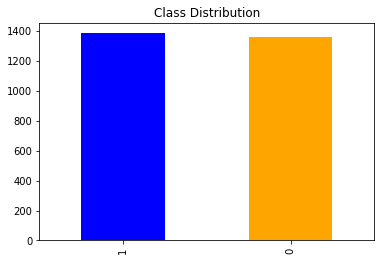

In [13]:
#Bar plot of class labels
plt.rcParams['figure.figsize'] = (6, 4)
count_Class=pd.value_counts(df["sentiment"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Class Distribution')
plt.show()

#### 3.1 Visualization of text length in positive and negative classes

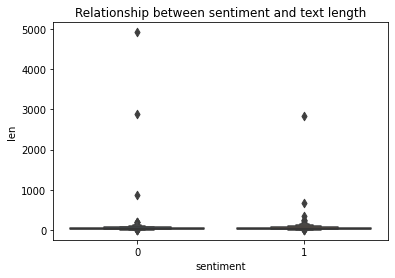

In [33]:
plt.rcParams['figure.figsize'] = (6, 4)
sns.boxenplot(x = df['sentiment'], y = df['len'])
plt.title('Relationship between sentiment and text length')
plt.show()

#### 3.2 Word frequency

In [15]:
neg_count = Counter(" ".join(df[df['sentiment']==0]["text"]).split()).most_common(20)
pos_count = Counter(" ".join(df[df['sentiment']==1]["text"]).split()).most_common(20)

neg_df = pd.DataFrame.from_dict(neg_count).rename(columns={0: "Words in negative class", 1 : "count"})
pos_df = pd.DataFrame.from_dict(pos_count).rename(columns={0: "Words in positive class", 1 : "count"})

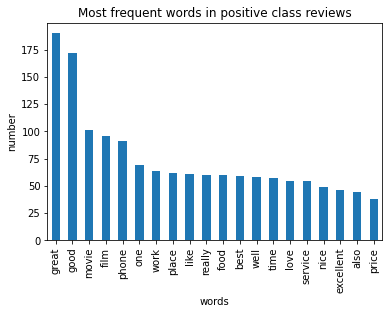

In [16]:
plt.rcParams['figure.figsize'] = (6, 4)
pos_df.plot.bar(legend = False)
y_pos = np.arange(len(pos_df["Words in positive class"]))
plt.xticks(y_pos, pos_df["Words in positive class"])
plt.title('Most frequent words in positive class reviews')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

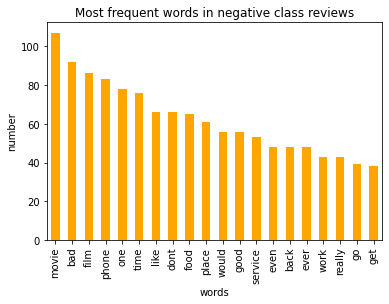

In [17]:
plt.rcParams['figure.figsize'] = (6, 4)
neg_df.plot.bar(legend = False, color='orange')
y_pos = np.arange(len(neg_df["Words in negative class"]))
plt.xticks(y_pos, neg_df["Words in negative class"])
plt.title('Most frequent words in negative class reviews')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

#### 3.3 Important Word - WordCloud

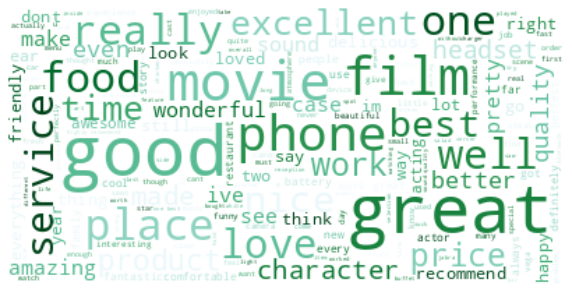

In [18]:
from wordcloud import WordCloud
text = ' '.join(df[df['sentiment']==1].text.values)
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white",  colormap='BuGn').generate(text.lower())
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

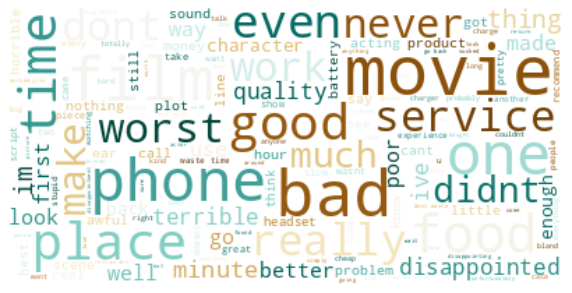

In [19]:
from wordcloud import WordCloud
text = ' '.join(df[df['sentiment']==0].text.values)
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white",  colormap='BrBG').generate(text.lower())
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Step 4: Train Test Data

In [20]:
X = df['text']
y = df['sentiment']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

In [22]:
print(X_train.shape, X_test.shape)

(2198,) (550,)


In [23]:
print("Samples per class in train {}".format(np.bincount(y_train)))
print("Samples per class in test {}".format(np.bincount(y_test)))

Samples per class in train [1071 1127]
Samples per class in test [291 259]


### Step 5: Feature Extraction using tf-idf scores
The feature value of a word in a sentence is defined by log(1 + 𝑡𝑓) ∗ log(𝑁/𝑑𝑓), where tf denotes the count of the word in the sentence, N is the total number of sentences in the training data and df denotes the number of sentences in the training data that contains the word.

In [26]:
# Create a TF-IDF vectorizer object 
vectorizer = TfidfVectorizer()
# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)
# Transform the testing data
X_test_tfidf = vectorizer.transform(X_test)
# print(X_train_tfidf)

### Step 6: Training Model

In [27]:
## Models and Hyperparameters
models = {
    'Multinomail Naive Bayes': MultinomialNB(),
    'Bernoulli Naive Bayes': BernoulliNB()
}

params = {
    'Multinomail Naive Bayes': { 'alpha': [0.1, 0.25, 0.5, 0.75, 1], 'fit_prior': [True, False] },
    'Bernoulli Naive Bayes': { 'alpha': [0.1, 0.25, 0.5, 0.75, 1], 'fit_prior': [True, False] }
}

In [28]:
# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train_tfidf, X_test_tfidf, y_train, y_test, performance_metrics):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]

        gs = GridSearchCV(model, param, cv=10, error_score=0, refit=True)
        gs.fit(X_train_tfidf, y_train)
        y_pred = gs.predict(X_test_tfidf)
        
        # Print scores for the classifier
        accuracy_sc = accuracy_score(y_test, y_pred)
        precision_sc= precision_score(y_test, y_pred, average='macro')
        recall_sc = recall_score(y_test, y_pred, average='macro')
        f1_sc =  f1_score(y_test, y_pred, average='macro')
        
        performance_metrics.append([key,accuracy_sc,precision_sc,recall_sc,f1_sc])
        print(key, ':', gs.best_params_) #print the best hyperparameters
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_sc, precision_sc, recall_sc, f1_sc))

        sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,  fmt='g')
        plt.show()
        
    return 

### Step 7: Evaluating Model

Multinomail Naive Bayes : {'alpha': 1, 'fit_prior': False}
Accuracy: 0.762 	Precision: 0.761 	Recall: 0.762 		F1: 0.761



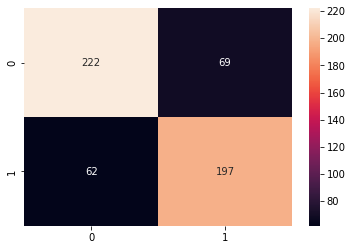

Bernoulli Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Accuracy: 0.784 	Precision: 0.786 	Recall: 0.786 		F1: 0.784



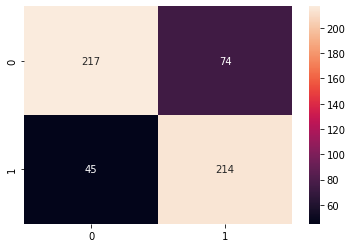

In [29]:
performance_metrics_tfidf = []
ML_modeling(models, params, X_train_tfidf, X_test_tfidf, y_train, y_test, performance_metrics_tfidf)
metrics_df = pd.DataFrame(performance_metrics_tfidf,columns=['Model' , 'Accuracy', 'Precision' , 'Recall', "F1 Score"])

In [30]:
#Final Results
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Multinomail Naive Bayes,0.761818,0.761146,0.761752,0.761325
1,Bernoulli Naive Bayes,0.783636,0.785650,0.785980,0.783630


# Misc

Extra Code

In [ ]:
#Without Sklearn -> our implementation
class TFIDFVectorizer:
    def __init__(self):
        self.vocab = set()
        self.idf = {}
        self.num_docs = 0

    def fit_transform(self, documents):
        # Fit the vectorizer on the given documents and transform them to TF-IDF vectors
        self.num_docs = len(documents)
        word_counts = [Counter(re.findall(r'\w+', doc.lower())) for doc in documents]
        self.vocab = set(word for word_count in word_counts for word in word_count.keys())
        self.idf = {word: math.log(self.num_docs / sum(1 for word_count in word_counts if word in word_count)) for word in self.vocab}
        print("Vocabulary size:", len(self.vocab))
        print("IDF values:", self.idf)
        return self.transform(documents)

    def transform(self, documents):
        # Transform the given documents to TF-IDF vectors
        vectors = []
        for doc in documents:
            word_count = Counter(re.findall(r'\w+', doc.lower()))
            vector = [word_count.get(word, 0) * self.idf[word] for word in self.vocab]
            vectors.append(vector)
        return vectors

In [ ]:
# Fit the TF-IDF vectorizer on the training data and transform both the training and test data to TF-IDF vectors
vectorizer = TFIDFVectorizer()
# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)
# Transform the testing data
X_test_tfidf = vectorizer.transform(X_test)

#print(X_train_tfidf)